In [ ]:
# https://forum.sentinel-hub.com/t/clm-error-in-eolearn-slovenia-land-cover-classification-script/2279/4

# https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html

#https://github.com/sentinel-hub/eo-learn/tree/master/example_data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, VectorImportTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection, SHConfig, BBoxSplitter

In [2]:
CLIENT_ID = "a44f965e-9afd-4ff8-b6b2-32536c40dcfb"
CLIENT_SECRET = "yh.d1_P@.)a|[@@|JWAx>kN~GX#SN5GgO^<E|)MH"
    
config = SHConfig()
config.instance_id = "8dcd8d01-01fb-419a-adbe-cd7b1b838b68"
    
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
if config.sh_client_id == "" or config.sh_client_secret == "" or config.instance_id == "":
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
# config.save()

/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
Dimension of the area is 249870 x 171656 m2


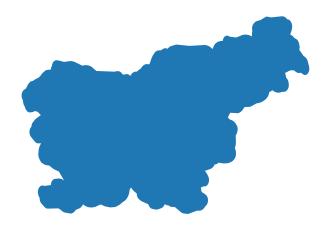

In [3]:
# Folder where data for running the notebook is located
DATA_FOLDER = os.path.join('.', 'example_data')

# Folder where data will be stored
EOPATCH_FOLDER = os.path.join('.', 'eopatches')
EOPATCH_SAMPLES_FOLDER = os.path.join('.', 'eopatches_sampled')
RESULTS_FOLDER = os.path.join('.', 'results')
os.makedirs(EOPATCH_FOLDER, exist_ok=True)
os.makedirs(EOPATCH_SAMPLES_FOLDER, exist_ok=True)
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'data.geojson'))

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})
# Get the country's shape in polygon format
country_shape = country.geometry.values[0]

# Plot country
country.plot()
plt.axis('off');

# Print size 
country_width = country_shape.bounds[2] - country_shape.bounds[0]
country_height = country_shape.bounds[3] - country_shape.bounds[1]
print(f'Dimension of the area is {country_width:.0f} x {country_height:.0f} m2')

In [4]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = BBoxSplitter([country_shape], country_crs, (25 * 3, 17 * 3))

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 1549 

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs={'init': CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

# save to shapefile
shapefile_name = os.path.join(RESULTS_FOLDER, 'grid_slovenia_500x500.gpkg')
gdf.to_file(shapefile_name)

/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()

,index_x,index_y,geometry
0,42,29,"POLYGON ((510157.617 5122327.229, 510157.617 5..."
1,43,29,"POLYGON ((513489.215 5122327.229, 513489.215 5..."
2,44,29,"POLYGON ((516820.812 5122327.229, 516820.812 5..."
3,42,28,"POLYGON ((510157.617 5118961.421, 510157.617 5..."
4,43,28,"POLYGON ((513489.215 5118961.421, 513489.215 5..."


/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.80695405)

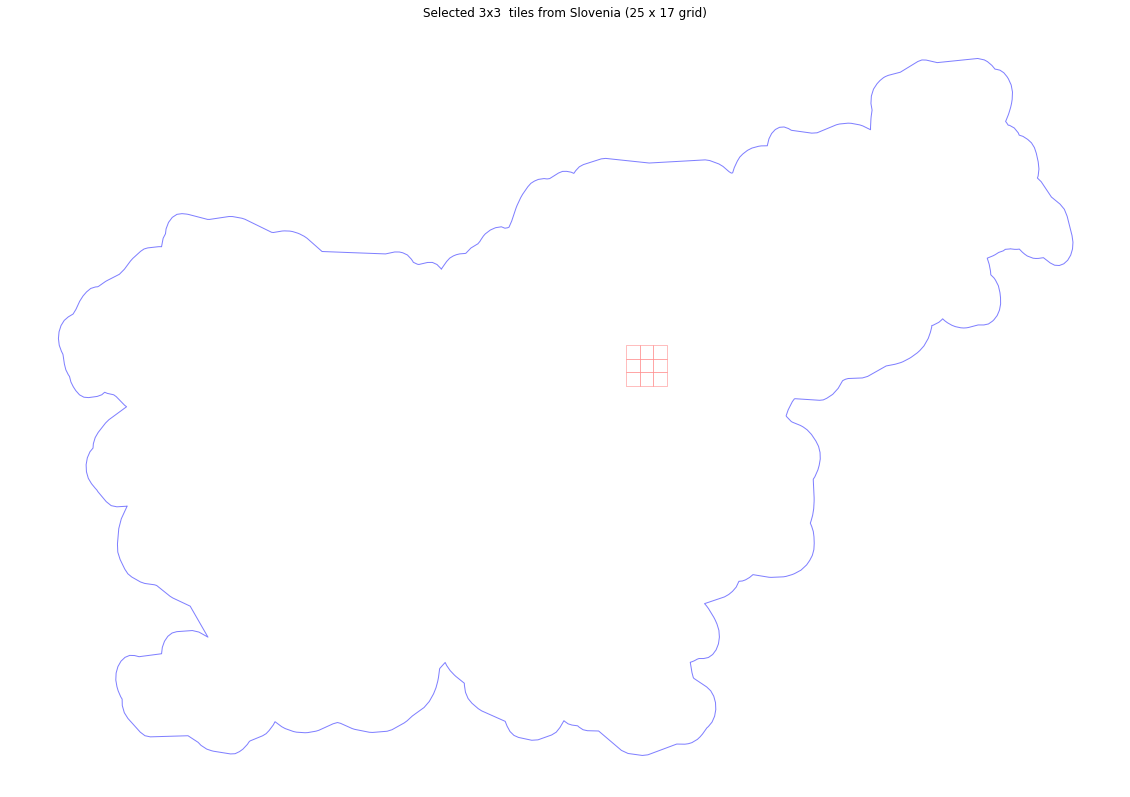

In [6]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia (25 x 17 grid)');
plt.axis('off')

In [7]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return eopatch.mask['IS_DATA'].astype(bool) & np.logical_not(eopatch.mask['CLM'].astype(bool))

class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[(FeatureType.MASK_TIMELESS, self.name)] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']

add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=5,
    config=config
)

# ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
# ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
# norm = EuclideanNorm('NORM','BANDS')



ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'),
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'),
                                     [band_names.index('B11'), band_names.index('B08')])



# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_validmask = AddValidDataMaskTask(SentinelHubValidData(), 'IS_VALID')

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask('IS_VALID', 'VALID_COUNT')

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [9]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    CULTIVATED_LAND    = 'Cultivated Land',    1,  '#ffff00'
    FOREST             = 'Forest',             2,  '#054907'
    GRASSLAND          = 'Grassland',          3,  '#ffa500'
    SHRUBLAND          = 'Shrubland',          4,  '#806000'
    WATER              = 'Water',              5,  '#069af3'
    WETLAND            = 'Wetlands',           6,  '#95d0fc'
    TUNDRA             = 'Tundra',             7,  '#967bb6'
    ARTIFICIAL_SURFACE = 'Artificial Surface', 8,  '#dc143c'
    BARELAND           = 'Bareland',           9,  '#a6a6a6'
    SNOW_AND_ICE       = 'Snow and Ice',       10, '#000000'

    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds


# Reference colormap things
lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

In [33]:
land_use_ref_path = os.path.join(DATA_FOLDER, 'land_use_10class_reference_slovenia_partial.gpkg')
vector_feature = FeatureType.VECTOR_TIMELESS, 'LULC_REFERENCE'

vector_import_task = VectorImportTask(vector_feature, land_use_ref_path)

rasterization_task = VectorToRaster(
    vector_feature,
    (FeatureType.MASK_TIMELESS, 'LULC'),
    values_column='lulcid',
    raster_shape=(FeatureType.MASK, 'IS_DATA'),
    raster_dtype=np.uint8
)

In [34]:

land_use_ref = gpd.read_file(land_use_ref_path)
land_use_ref

,RABA_PID,RABA_ID,VIR,AREA,STATUS,D_OD,lulcid,lulcname,geometry
0,3110752.0,1211,Dof5,347.1811,P,2017-01-18,1,cultivated land,"MULTIPOLYGON (((507731.929 5133466.890, 507725..."
1,1999627.0,1300,Dof5,1598.0406,P,2016-12-13,3,grassland,"MULTIPOLYGON (((503154.369 5122699.978, 503160..."
2,5163032.0,3000,Dof5,178.3287,P,2017-12-12,8,artificial surface,"MULTIPOLYGON (((515880.695 5128551.509, 515896..."
3,5032941.0,1222,Dof5,1604.5896,P,2017-03-01,1,cultivated land,"MULTIPOLYGON (((508473.586 5118831.396, 508481..."
4,5479898.0,1500,Dof5,326.2020,P,2016-12-13,4,schrubland,"MULTIPOLYGON (((520167.779 5125174.744, 520165..."
...,...,...,...,...,...,...,...,...,...
47939,5852158.0,1300,dof,27666.4130,P,2018-05-22,3,grassland,"MULTIPOLYGON (((520275.772 5126653.355, 520277..."
47940,5852159.0,1221,dof,6448.3854,P,2018-05-22,1,cultivated land,"MULTIPOLYGON (((520517.482 5126469.748, 520507..."
47941,3190512.0,1300,Dof5,1420.1473,P,2017-01-16,3,grassland,"MULTIPOLYGON (((514151.975 5126664.569, 514148..."
47942,363999.0,1300,Baseline_2,413.0511,P,2017-01-23,3,grassland,"MULTIPOLYGON (((515444.913 5126458.749, 515440..."


/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


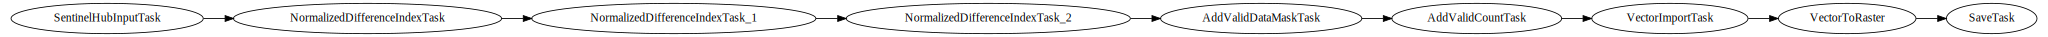

In [35]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    ndvi,
    ndwi,
    ndbi,
    add_sh_validmask,
    add_valid_count,
    vector_import_task,
    rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [36]:
%%time

# Time interval for the SH request
time_interval = ['2021-01-15', '2021-05-20']

# Define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data: {'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

  0%|          | 0/9 [00:00<?, ?it/s]

/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/pyproj/transformer.py:464: DeprecationWarning: skip_equivalent is deprecated.
  return Transformer.from_crs(
/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/pyproj/transformer.py:464: DeprecationWarning: skip_equivalent is deprecated.
  return Transformer.from_crs(
/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/pyproj/transformer.py:464: DeprecationWarning: skip_equivalent is deprecated.
  return Transformer.from_crs(
/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/pyproj/transformer.py:464: DeprecationWarning: skip_equivalent is deprecated.
  return Transformer.from_crs(
/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/pyproj/transformer.py:464: DeprecationWarning: skip_equivalent is deprecated.
  return Transformer.from_crs(
CPU times: user 92.5 ms, sys: 229 ms, total: 321 ms
Wall time: 56.3 s


In [42]:
EOPatch.load('./eopatches/eopatch_0/')

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(30, 337, 333, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(30, 337, 333, 1), dtype=uint8)
    NDBI: numpy.ndarray(shape=(30, 337, 333, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(30, 337, 333, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(30, 337, 333, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(30, 337, 333, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(30, 337, 333, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(30, 337, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    LULC_REFERENCE: geopandas.GeoDataFrame(columns=['RABA_PID', 'RABA_ID', 'VIR', 'AREA', 'STATUS', 'D_OD', 'lulcid', 'lulcname', 'geometry'], length=1374, crs=EPSG:32633)
  }
  meta_info

  0%|          | 0/9 [00:00<?, ?it/s]

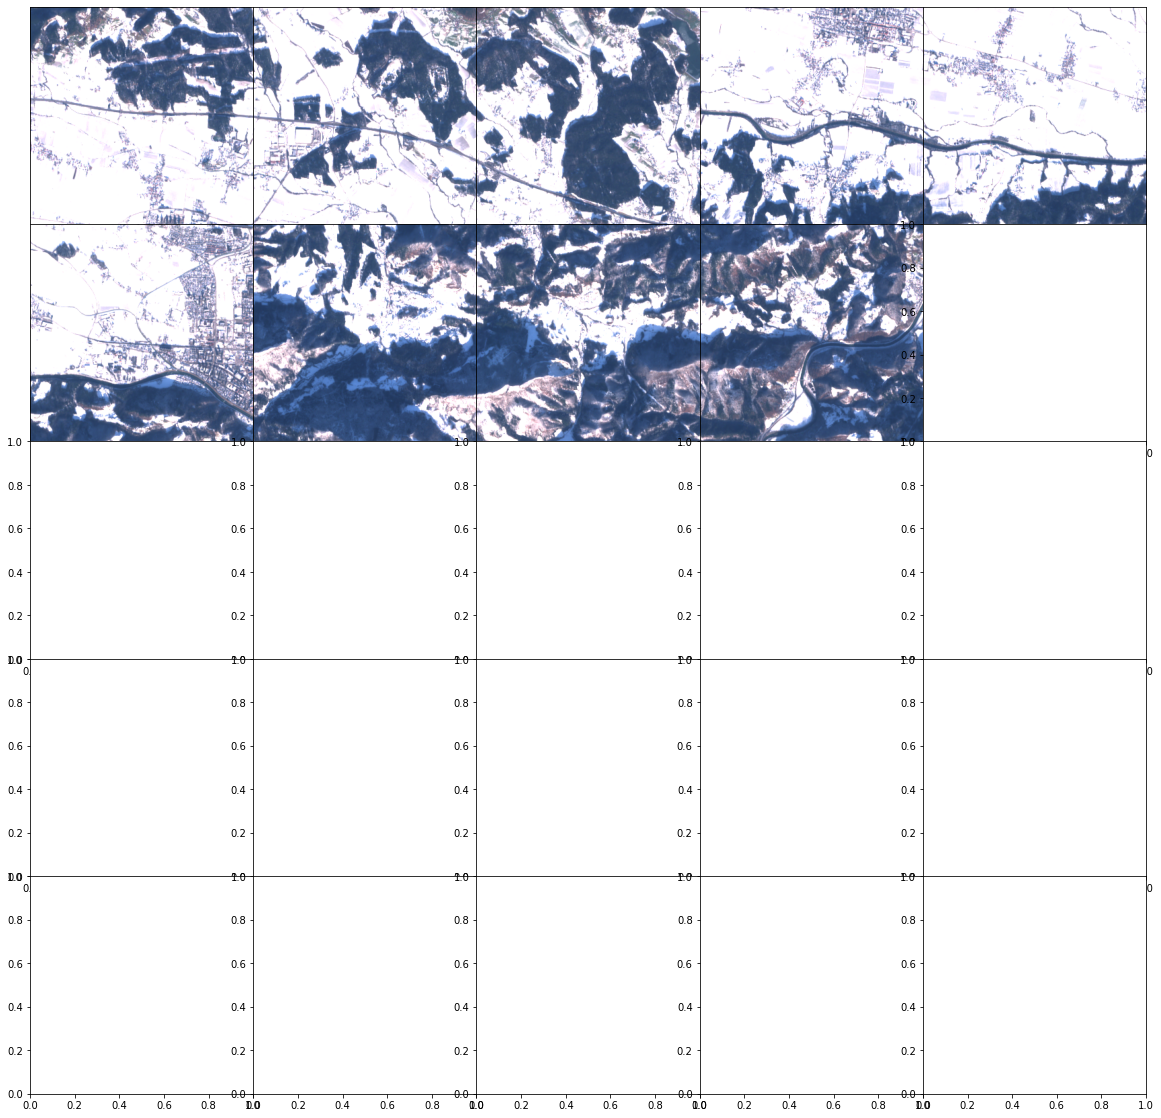

In [43]:
# Draw the RGB images
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

date = datetime.datetime(2019, 7, 1)

for i in tqdm(range(len(patchIDs))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f'eopatch_{i}')
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    dates = np.array([timestamp.replace(tzinfo=None) for timestamp in eopatch.timestamp])
    closest_date_id = np.argsort(abs(date-dates))[0]

    ax = axs[i//5][i%5]
    ax.imshow(np.clip(eopatch.data['BANDS'][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

  0%|          | 0/9 [00:00<?, ?it/s]

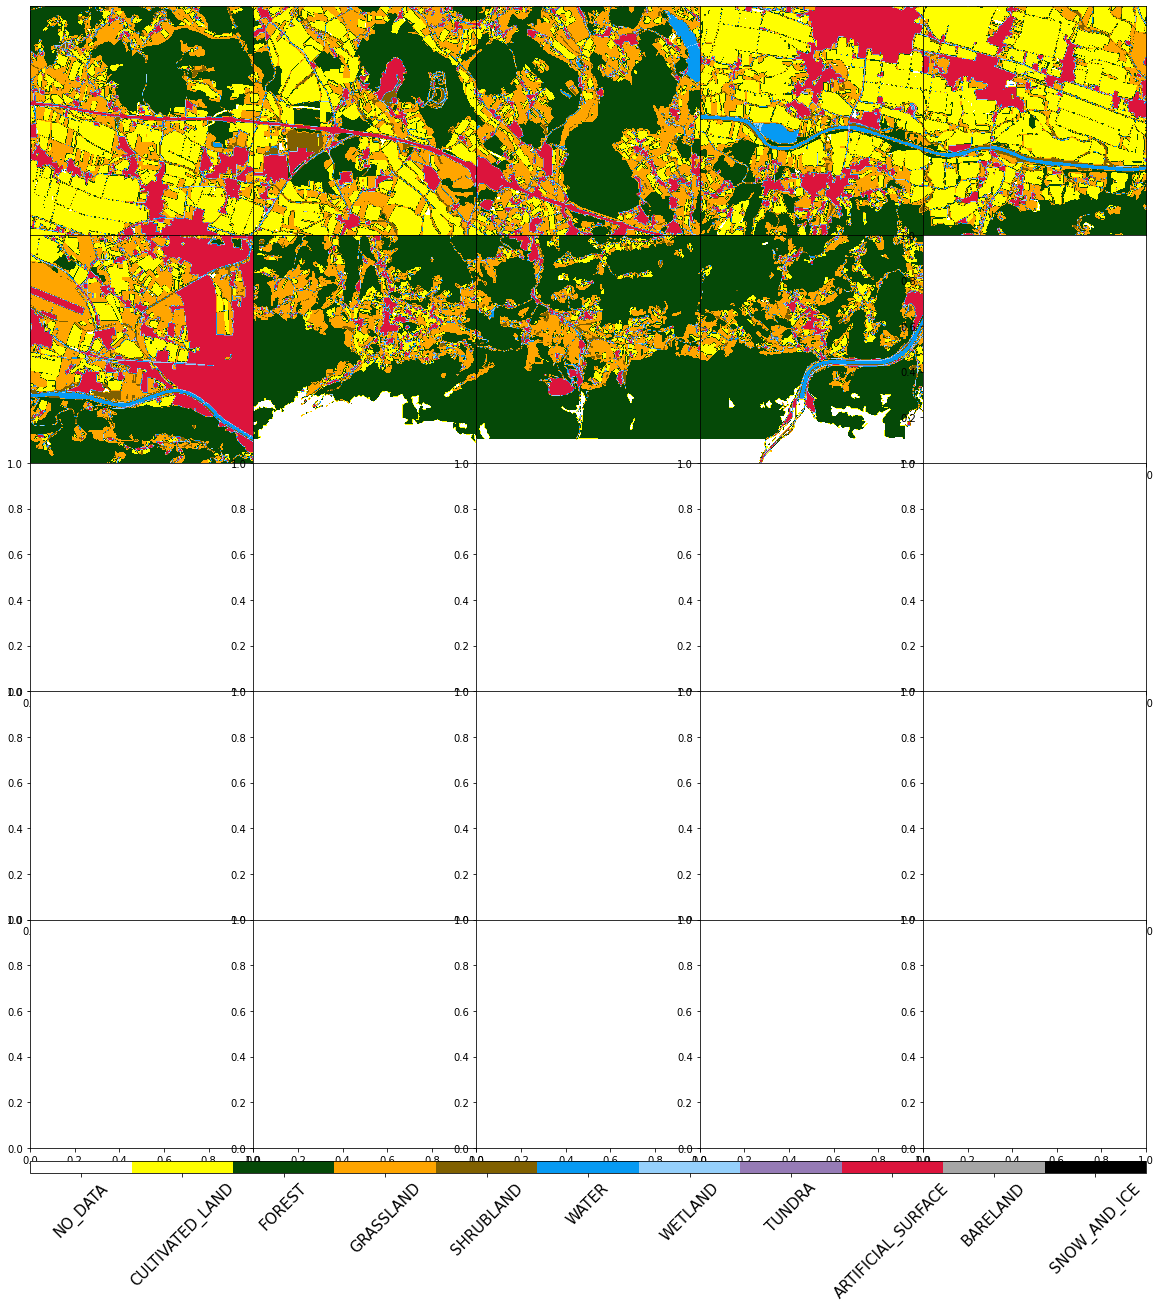

In [44]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f'eopatch_{i}')
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i//5][i%5]
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show()

In [45]:
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [46]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_FOLDER)

# FEATURE CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ['BANDS', 'NDVI', 'NDWI', 'NDBI']},
                               (FeatureType.DATA, 'FEATURES'))

# FILTER OUT CLOUDY SCENES
# Keep frames with > 80% valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# LINEAR TEMPORAL INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2019-01-01', '2019-12-31', 15)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range,
)

# EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# SPATIAL SAMPLING
# Uniformly sample pixels from patches
n_samples = 125000 # half of pixels
lulc_type_ids = [lulc_type.id for lulc_type in LULC]

spatial_sampling = PointSamplingTask(
    n_samples=n_samples,
    ref_mask_feature='LULC_ERODED',
    ref_labels=lulc_type_ids,
    sample_features=[(FeatureType.DATA, 'FEATURES'), (FeatureType.MASK_TIMELESS, 'LULC_ERODED')],
    )

save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [47]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)

In [48]:
%%time

execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': f'eopatch_{idx}'},
        spatial_sampling: {'seed': 42},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 348 ms, sys: 210 ms, total: 558 ms
Wall time: 4min 40s


In [49]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patchIDs)):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f'eopatch_{i}')
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

In [60]:
sampled_eopatches

[EOPatch(
   data: {
     FEATURES: FeatureIO(/data/FEATURES.npy)
     FEATURES_SAMPLED: FeatureIO(/data/FEATURES_SAMPLED.npy)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {
     LULC: FeatureIO(/mask_timeless/LULC.npy)
     LULC_ERODED: FeatureIO(/mask_timeless/LULC_ERODED.npy)
     LULC_ERODED_SAMPLED: FeatureIO(/mask_timeless/LULC_ERODED_SAMPLED.npy)
   }
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((510157.61722214246, 5122327.229129893), (513489.214628833, 5125693.036780571)), crs=CRS('32633'))
   timestamp: [datetime.datetime(2019, 1, 1, 0, 0), ..., datetime.datetime(2019, 12, 27, 0, 0)], length=25
 ),
 EOPatch(
   data: {
     FEATURES: FeatureIO(/data/FEATURES.npy)
     FEATURES_SAMPLED: FeatureIO(/data/FEATURES_SAMPLED.npy)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {
     LULC: FeatureIO(/mask_timeless/LULC.npy)
     

In [61]:
# Definition of the train and test patch IDs, take 80 % for train
test_ID = [0, 6]
test_eopatches = [sampled_eopatches[i] for i in test_ID]
train_ID = [i for i in range(len(patchIDs)) if i not in test_ID]
train_eopatches = [sampled_eopatches[i] for i in train_ID]

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in train_eopatches])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in train_eopatches])

features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in test_eopatches])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in test_eopatches])

# Get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# Reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h)
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h)

# Remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# Remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]

In [62]:
features_train.shape

(609463, 225)

In [63]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(labels_unique),
    metric='multi_logloss',
    random_state=42
)

# Train the model
model.fit(features_train, labels_train)

# Save the model
joblib.dump(model, os.path.join(RESULTS_FOLDER, 'model_SI_LULC.pkl'))

CPU times: user 26 s, sys: 0 ns, total: 26 s
Wall time: 4.2 s


['./results/model_SI_LULC.pkl']

In [64]:
# Load the model
model_path = os.path.join(RESULTS_FOLDER, 'model_SI_LULC.pkl')
model = joblib.load(model_path)

# Predict the test labels
predicted_labels_test = model.predict(features_test)

In [65]:
class_labels = np.unique(labels_test)
class_names = [lulc_type.name for lulc_type in LULC]
mask = np.in1d(predicted_labels_test, labels_test)
predictions = predicted_labels_test[mask]
true_labels = labels_test[mask]

# Extract and display metrics
f1_scores = metrics.f1_score(true_labels, predictions, labels=class_labels, average=None)
avg_f1_score = metrics.f1_score(true_labels, predictions, average='weighted')
recall = metrics.recall_score(true_labels, predictions, labels=class_labels, average=None)
precision = metrics.precision_score(true_labels, predictions, labels=class_labels, average=None)
accuracy = metrics.accuracy_score(true_labels, predictions)

print('Classification accuracy {:.1f}%'.format(100 * accuracy))
print('Classification F1-score {:.1f}%'.format(100 * avg_f1_score))
print()
print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    line_data = (lulctype, f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100)
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(*line_data))

Classification accuracy 51.0%
Classification F1-score 34.4%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * CULTIVATED_LAND      = 0.0 |  0.0  | 0.0
         * FOREST               = 67.5 |  100.0  | 51.0
         * GRASSLAND            = 0.0 |  0.0  | 0.0
         * SHRUBLAND            = 0.0 |  0.0  | 0.0
         * WATER                = 0.0 |  0.0  | 0.0
         * ARTIFICIAL_SURFACE   = 0.0 |  0.0  | 0.0
/home/vlasisss/miniconda3/envs/land_cover/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/vlasisss/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Pre